# Financial Statistics 

## Group Assignment

### Date: 27-Nov-25

### Group members: Andrew Armando, Bolun Tian, Jiaqi Hou, Sylvia Venizelou, Ze Wei Ong

# Table of contents
1. [Introduction](#introduction)
3. [Question 1 (CAPM)](#Q1)
4. [Question 2 (probability of a positive return)](#Q2)
5. [Question 3 (CIR model for the term structure of interest rate)](#Q3)

# Introduction <a name="introduction"></a>
In this document, we will present solutions to questions 1, 2 and 3 of the group assignment.

# Question 1 (CAPM) <a name="Q1"></a>

## Importing of libraries

In [22]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
from itertools import combinations 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
# read the excel data
df_raw = pd.read_excel('data_coursework_Q1.xls')

Selecting relevant columns and clean the raw data frame by only keeping 3 columns we need for the CAPM analysis:
1) SP500
2) IBM
3) 1-month Tbill

Then convert these columns to numeric values and coerce any non-numeric entries to drop rows containing missing values.

In [24]:
# SP500: market price/index level
# IBM: stock price
# 1-m Tbill: risk-free rate (given data is multiplied by 100 and in month)
prices = df_raw[["SP500", "IBM", "1-month Tbill"]].copy()

prices["SP500"] = pd.to_numeric(prices["SP500"], errors="coerce")
prices["IBM"] = pd.to_numeric(prices["IBM"], errors="coerce")
prices["1-month Tbill"] = pd.to_numeric(prices["1-month Tbill"], errors="coerce")
prices = prices.dropna(subset=["SP500", "IBM", "1-month Tbill"]).reset_index(drop=True)

## Monthly returns and risk-free rate

- `r_M`: simple monthly market return, calculated from SP 500 price series using `pct_change()` 
- `r_IBM`: simple monthly stock return for IBM  
- `r_f`: monthly risk-free rate (dividing the 1-month T-bill rate by 100)

We drop the first row and any remaining rows with missing values to create clean data dataframe `df`

In [25]:
# simple monthly returns
prices["r_M"] = prices["SP500"].pct_change()      # market
prices["r_IBM"] = prices["IBM"].pct_change()      # stock

# T-bill given is multiplied by 100 and not expressed in yearly basis
prices["r_f"] = prices["1-month Tbill"] / 100.0

# drop first row and any NaNs
df = prices.dropna(subset=["r_IBM", "r_M", "r_f"]).reset_index(drop=True)

## Excess returns and CAPM regressors

Define the excess returns for the stock and the market:

$$
r_{IBM} - r_{f} \quad \text{and} \quad r_{M} - r_{f},
$$

where
- $r_{IBM}$ is the return on IBM at time $t$,
- $r_{M}$ is the market (S\&P 500) return at time $t$,
- $r_{f}$ is the risk-free rate (1-month T-bill) at time $t$.


For different sensitivities in up and down markets, we define the indicator

$$
D_t =
\begin{cases}
1, & \text{if } r_{M} - r_{f} > 0 \quad (\text{up market}), \\
0, & \text{if } r_{M} - r_{f} \le 0 \quad (\text{down / non-up market}).
\end{cases}
$$

The regressors in Model (2) 
$$
D_t(r_{M} - r_{f}), \qquad
(1-D_t)(r_{M} - r_{f}), \qquad
(r_{M} - r_{f})^2.
$$


- $D_t = 1$ if $r_M - r_f > 0$ (up market), and $D_t = 0$ otherwise (down / non-up market).
- $D_t (r_M - r_f)$: market excess return in up markets ($\beta_1$).
- $(1-D_t)(r_M - r_f)$: market excess return in down markets ($\beta_2$).
- $(r_M - r_f)^2$: squared market excess return, capturing possible nonlinear effects ($\beta_3$).



In [26]:
# excess returns & 2 regressors
df["Excess_R_IBM"] = df["r_IBM"] - df["r_f"]
df["Excess_R_M"] = df["r_M"] - df["r_f"]

# indicator: up vs down markets based on market excess return
Dt = (df["Excess_R_M"] > 0).astype(int)

# beta 1,2,3
df["X1_U_M"] = Dt * df["Excess_R_M"]          
df["X2_D_M"] = (1 - Dt) * df["Excess_R_M"] 
df["X3_Squared"] = df["Excess_R_M"] ** 2       

print("Regression data:")
print(df[["Excess_R_IBM", "Excess_R_M", "X1_U_M", "X2_D_M", 
          "X3_Squared"]].head(), "\n")

Regression data:
   Excess_R_IBM  Excess_R_M   X1_U_M    X2_D_M  X3_Squared
0     -0.013152    0.014650  0.01465  0.000000    0.000215
1     -0.009519   -0.001003 -0.00000 -0.001003    0.000001
2     -0.149927   -0.034068 -0.00000 -0.034068    0.001161
3     -0.135733   -0.076757 -0.00000 -0.076757    0.005892
4     -0.140462   -0.118844 -0.00000 -0.118844    0.014124 



## Standard CAPM

We estimate the standard CAPM regression:

$$
r_{IBM} - r_{f} = \alpha + \beta (r_{M} - r_{f}) + u_t
$$

using OLS, with `Excess_R_IBM` as the dependent variable and `Excess_R_M` as the regressor.

The OLS estimators in simple regressions are:

$$
\hat{\beta}
= \frac{\text{Cov}(r_{IBM}-r_f,\; r_M-r_f)}
{\text{Var}(r_M-r_f)},
$$

$$
\hat{\alpha}
= 
\overline{(r_{IBM}-r_f)} 
\;-\;
\hat{\beta}\,\overline{(r_M - r_f)}.
$$

To test the null hypothesis $H_0:\alpha = 0$ we use the t-statistic:

$$
t = \frac{\hat{\alpha}}{\text{se}(\hat{\alpha})}.
$$

- $\hat{\alpha}$: the estimated abnormal return.
- $\hat{\beta}$: IBM’s systematic risk relative to the market.
- The t-test for $H_0:\ \alpha = 0$ checks if the alpha is statistically different from zero.


In [ ]:
# regression analysis
print("\n Model 1: Standard CAPM (OLS)")
# dependent v = Ri,t     independent v = RM,t
capm = ols("Excess_R_IBM ~ Excess_R_M", data=df).fit()

import re
raw_text = capm.summary().as_text()
# Replace values that appear as "0.000" with a scientific notation placeholder
def replace_small_numbers(text):
    pattern = r'(?<!\d)0\.000(?!\d)'   # Match isolated "0.000" 
    return re.sub(pattern, '1e-3', text) 

formatted_text = replace_small_numbers(raw_text)

print(formatted_text)

# t-test: H0: α = 0 in model 1
print("\n t-Test for H_0: alpha = 0")
t_stat = capm.tvalues["Intercept"]
p_val = capm.pvalues["Intercept"]

print(f"t-statistic: {t_stat:.5f}")
print(f"P-value: {p_val:.5f}")

if p_val < 0.05:
    print("Decision: We reject H_0. Alpha is different from zero at 5% significance level.")
else:
    print("Decision: Fail to reject H_0. Alpha is not statistically different from zero at 5% significance level.")


 Model 1: Standard CAPM (OLS)
                            OLS Regression Results                            
Dep. Variable:           Excess_R_IBM   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     138.4
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           4.24e-27
Time:                        02:36:21   Log-Likelihood:                 543.44
No. Observations:                 347   AIC:                            -1083.
Df Residuals:                     345   BIC:                            -1075.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027

### Interpretation of the t-test for $H_0 : \alpha = 0$

From Model 1 we get:
- t-statistic for $\alpha$: approximately $0.99$,
- p-value: approximately $0.32$.

At the 5% significance level, the p-value is larger than 0.05, so that we fail to reject the null hypothesis

Under the observation of the sample, there is no statistical evidence that IBM’s alpha is
different from zero.




## Extended Asymmetric CAPM

Extend CAPM so that we have different betas in up and down markets and a possible nonlinear effect

$$
r_{IBM} - r_f
= \alpha
+ \beta_1 D_t (r_M - r_f)
+ \beta_2 (1-D_t)(r_M - r_f)
+ \beta_3 (r_M - r_f)^2
+ u_t .
$$


- $D_t = 1$ if $r_M - r_f > 0$ (up market), and $D_t = 0$ otherwise (down / non-up market).
- The regressors: $D_t(r_M - r_f)$, $(1-D_t)(r_M - r_f)$ and $(r_M - r_f)^2$.
- $\beta_1$ is the up-market beta, $\beta_2$ is the down-market beta, and $\beta_3$ captures non-linear effects of the market excess return.

We estimate this model by OLS using `Excess_R_IBM` as the dependent variable and
`X1_U_M`, `X2_D_M`, `X3_Squared` as the regressors.


In [ ]:
print("\n Model 2: Extended Asymmetric Model (OLS)")
# 3 variables β (1,2,3)
extended_model = ols("Excess_R_IBM ~ X1_U_M + X2_D_M + X3_Squared", 
                     data=df).fit()

import re
raw_text_ext = extended_model.summary().as_text()
# Replace rounded zeros ("0.000") with a scientific-notation placeholder
def replace_small_numbers(text):
    pattern = r'(?<!\d)0\.000(?!\d)'   # Match isolated occurrences of "0.000"
    return re.sub(pattern, '1e-3', text)  

formatted_text_ext = replace_small_numbers(raw_text_ext)

print(formatted_text_ext)

# hyphotesis test
# F-Test: H0: β1 = β2 in model 2
print("\n F-Test for H_0: beta_1 = beta_2")
f_test_result = extended_model.f_test("X1_U_M = X2_D_M")
F_stat = float(f_test_result.fvalue)
F_pval = float(f_test_result.pvalue)

print(f"F-statistic: {F_stat:.5f}")
print(f"P-value: {F_pval:.5f}")

if F_pval < 0.05:
    print("Decision: We reject H_0. The up and down market betas are significantly different under the observed data.")
else:
    print("Decision: We fail to reject H_0. No significant difference in betas under the observed data.")


 Model 2: Extended Asymmetric Model (OLS)
                            OLS Regression Results                            
Dep. Variable:           Excess_R_IBM   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     48.87
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           2.53e-26
Time:                        02:37:43   Log-Likelihood:                 546.66
No. Observations:                 347   AIC:                            -1085.
Df Residuals:                     343   BIC:                            -1070.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

### Interpretation of the F-test for $H_0 : \beta_1 = \beta_2$

In Model 2 we test
$$
H_0 : \beta_1 = \beta_2
\quad \text{vs} \quad
H_1 : \beta_1 \neq \beta_2,
$$

Check whether IBM beta is the same in up and down markets.

A small p-value (below 5%) leads us to reject $H_0$ and conclude that the up-market and down-market betas are significantly different under the observed data.

If the p-value is above 5%, we will fail to reject $H_0$ and there is no statistical evidence
that the betas will be different during up and down markets.


# Question 2 (probability of a positive asset return) <a name="Q2"></a>

## Reading of dataset

Since the "date" column of the data was written in Italian, I converted it to the standard date format in order to analyse my data.

In [29]:
factors = pd.read_excel('data_coursework_Q2_edited.xls', sheet_name = 'final_m')

FileNotFoundError: [Errno 2] No such file or directory: 'data_coursework_Q2_edited.xls'

## Part a: estimation of linear regression model via OLS

In Question 2, we first create a binary indicator variable be transforming the equity market index return $R_t$ into 1's and 0's via $Y_t$ which is defined as:

$$
Y_t =
\begin{cases}
1, & \text{if } R_t > 0, \\
0, & \text{if } R_t \le 0.
\end{cases}
$$

which can then be re-written as a conditional expectation as follows:

$$
P(R_{t+1} > 0 \mid X_t) = E(Y(R_{t+1}) \mid X_t)
$$

where $X_t$ denotes the set of regressors (predictors) observed at time t.

**For United States (US) returns:**

$$
X_t^{\text{US}} = ( \text{UDY}_t,\; \text{UIF}_t,\; \text{UOIL}_t,\; \text{URR}_t )
$$

**For Eurozone (EMU) returns:**

$$
X_t^{\text{EMU}} = ( \text{EDY}_t,\; \text{EFX}_t,\; \text{EIF}_t,\; \text{ERECB}_t,\; \text{ESP}_t )
$$

---

### Justification of the model and predictor variables chosen

I chose 2 separate models to study stock returns of the United States and Europe since they belong to separate economies.

I also chose all the factors given in the dataset as potential predictors for the stock returns with my justifications outlined below.

**Predictors for Eurozone (EMU)**

**Dividend yield (EDY):**\
A high dividend yield normally means that stock prices today tend to be cheaper compared to their dividends, indicating high risk sentiment in the market. The risk premium is therefore higher and the market is expected to generate higher returns.

**Euro/dollar exchange rate (EFX):**\
Currency movements capture the macroeconomic conditions of a country or countries within the similar region and market returns closely tie in with macroeconomic events.

**Inflation rate (EIF):**\
If inflation is high, investors expect the central banks to increase interest rates and therefore cause prices in the stock marekt to decrease and hence lowers the returns.

**Rate level (ERECB):**\
Historically, there is a negative correlation between market returns and the interest rate as lower interest rates allows investments and the cost of borrowing to be cheaper, thus increasing market returns.

**Term spread (ESP):**\
The term spread is defined as the long-term yield minus short-term yield. WIth a wider term spread, investors are optimistic about the economy and expect short-term interest rates to rise and markets to grow, hence boosting stock returns. 

**Predictors for United States (US)**

**Dividend yield (UDY):**\
Same reasoning as the rate level for Europe's market returns.

**Inflation rate (UIF):**\
Same reasoning as the rate level for Europe's market returns.

**Variation in oil price (t/t-1) (UOIL):**\
If oil prices rise, this can lead to rise in inflation in the US economy which can cause the FED to increase interest rates. Companies that rely on oil can also see their profit margins decrease and hence a lower overall market return.

**Rate level (URR):**\
Same reasoning as the rate level for Europe's market returns.

---
Now, to estimate the conditional expectation, we use the linear regression model:

$$
Y_{t+1} = \beta' X_t + \varepsilon_t,
\qquad t = 1, \ldots, n-1.
$$

where the estimated probability will then be: 

$$
\hat{P}(R_{t+1} > 0 \mid X_t) = \hat{\beta}' X_t, \quad t = 1,2,\ldots,n-1.
$$

where $\hat{\beta}$ is the OLS estimator.

In [ ]:
# Transform USR and ESR into indicator variables 
# Contruct indicator variables (Y) \ 
# where Y = 1 if return > 0 and Y = 0 if return <= 0
factors['Y_USR'] = np.where(factors['USR'] > 0, 1, 0)
factors['Y_ESR'] = np.where(factors['ESR'] > 0, 1, 0)

# Construct predictors (X) for USR and ESR
pred_USR = ['UDY','UIF','UOIL','URR']
X_USR = factors[pred_USR]

pred_ESR = ['EDY','EFX','EIF','ERECB','ESP']
X_ESR = factors[pred_ESR]

# add intercept term to linear regression model 
X_USR = sm.add_constant(X_USR)
X_ESR = sm.add_constant(X_ESR)

# Move indicator variables one time frame forward (i.e. Y_(t+1)) 
factors['Y_USR_forward'] = factors['Y_USR'].shift(-1)
factors['Y_ESR_forward'] = factors['Y_ESR'].shift(-1)

# remove both NA values of last row for indicator variables and \
# values of last row for predictors 
f_new = factors.drop(index=factors.index[-1])

# update variables for new dataframe 
f_new['Y_USR_forward'] = factors['Y_USR_forward'] 
f_new['Y_ESR_forward'] = factors['Y_ESR_forward']

# update predictor terms for new dataframe 
X_USR_new = f_new[pred_USR]
X_ESR_new = f_new[pred_ESR]

# add intercept terms for new dataframe
X_USR_new = sm.add_constant(X_USR_new)
X_ESR_new = sm.add_constant(X_ESR_new)

# Construct dependent variable for OLS python package 
Y_US = f_new['Y_USR_forward']
Y_EMU = f_new['Y_ESR_forward']

The Ordinary Least Squares (OLS) estimator chooses the coefficient vector $\beta\$ that minimizes the sum of squared residuals:

$$
\hat{\beta}
= \arg\min_{\beta}
\sum_{t=1}^{n-1} (Y_{t+1} - \beta' X_t)^2.
$$

In closed form, the OLS estimator is:

$$
\hat{\beta} = (X'X)^{-1} X'Y.
$$

In Python, this can be solved numerically via the sm.OLS() function by importing the statsmodels package. The code is shown below:

In [ ]:
# linear regression model using OLS numerical method
OLS_model_US = sm.OLS(Y_US,X_USR_new).fit()
OLS_model_EMU = sm.OLS(Y_EMU,X_ESR_new).fit()

### Results for US Market

In [ ]:
# coefficient table 
tbl_US = pd.DataFrame({
    'coef': OLS_model_US.params,
    'std_err': OLS_model_US.bse,
    't_value': OLS_model_US.tvalues,
    'p_value': OLS_model_US.pvalues })

tbl_US.head()

,coef,std_err,t_value,p_value
const,0.616131,0.092201,6.682459,1.232811e-10
UDY,0.138937,0.080363,1.728882,8.491314e-02
UIF,-7.206594,3.096377,-2.327428,2.064289e-02
UOIL,-0.625994,0.290884,-2.152038,3.223416e-02
URR,0.067117,0.046194,1.452944,1.473396e-01


In [ ]:
# statistics of the model 
stats_US = {
    'R_squared': OLS_model_US.rsquared,
    'F_statistic': OLS_model_US.fvalue,
    'F_pvalue': OLS_model_US.f_pvalue}

print(stats_US)

{'R_squared': 0.037258303671175996, 'F_statistic': 2.7573898031986737, 'F_pvalue': 0.028191982216253266}


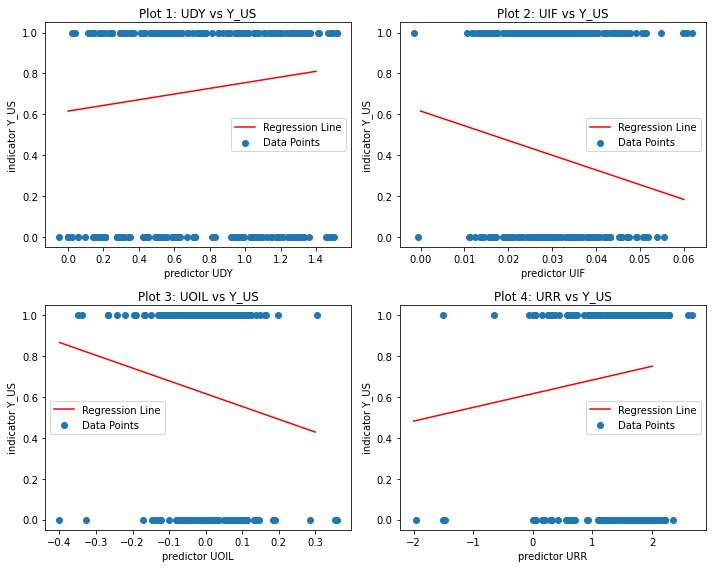

In [ ]:
# plot a scatter graph for predictors vs indicator variables
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# data for plotting of linear regression line
x1_plot = np.linspace(0,1.4,100)
x2_plot = np.linspace(0,0.06,100)
x3_plot = np.linspace(-0.4,0.3,100)
x4_plot = np.linspace(-2,2,100)

y1_plot = x1_plot*OLS_model_US.params[1] + OLS_model_US.params[0]
y2_plot = x2_plot*OLS_model_US.params[2] + OLS_model_US.params[0]
y3_plot = x3_plot*OLS_model_US.params[3] + OLS_model_US.params[0]
y4_plot = x4_plot*OLS_model_US.params[4] + OLS_model_US.params[0]

# first plot 
ax[0,0].scatter(f_new['UDY'], Y_US, label='Data Points') 
ax[0,0].plot(x1_plot, y1_plot, color='red', label='Regression Line') 
ax[0,0].set_title('Plot 1: UDY vs Y_US')
ax[0,0].set_xlabel('predictor UDY')
ax[0,0].set_ylabel('indicator Y_US')
ax[0,0].legend()

# second plot 
ax[0,1].scatter(f_new['UIF'], Y_US, label='Data Points') 
ax[0,1].plot(x2_plot, y2_plot, color='red', label='Regression Line') 
ax[0,1].set_xlabel('predictor UIF')
ax[0,1].set_ylabel('indicator Y_US')
ax[0,1].set_title('Plot 2: UIF vs Y_US')
ax[0,1].legend()

# third plot 
ax[1,0].scatter(f_new['UOIL'], Y_US, label='Data Points') 
ax[1,0].plot(x3_plot, y3_plot, color='red', label='Regression Line') 
ax[1,0].set_title('Plot 3: UOIL vs Y_US')
ax[1,0].set_xlabel('predictor UOIL')
ax[1,0].set_ylabel('indicator Y_US')
ax[1,0].legend()

# fourth plot 
ax[1,1].scatter(f_new['URR'], Y_US, label='Data Points') 
ax[1,1].plot(x4_plot, y4_plot, color='red', label='Regression Line') 
ax[1,1].set_title('Plot 4: URR vs Y_US')
ax[1,1].set_xlabel('predictor URR')
ax[1,1].set_ylabel('indicator Y_US')
ax[1,1].legend()

plt.tight_layout()
plt.savefig('high_quality_plot.png', dpi=300) 
plt.show()

**Analysis**:

From our plots, we can tell that the OLS method is very bad at modelling binary outputs as the regression line do not touch the data points at all. For further and more accurate studies, a logistic regression may be a better representation instead. 

Both URR and UDY appears to have a positive relationship with the indicator variable while UOIL and UIF has a negative relationship.

### Results for Eurozone Market

In [ ]:
# coefficient table 
tbl_EMU = pd.DataFrame({
    'coef': OLS_model_EMU.params,
    'std_err': OLS_model_EMU.bse,
    't_value': OLS_model_EMU.tvalues,
    'p_value': OLS_model_EMU.pvalues })

tbl_EMU.head()

,coef,std_err,t_value,p_value
const,0.696399,0.190021,3.664848,0.000295
EDY,0.030403,0.134654,0.225784,0.821532
EFX,0.405668,0.912532,0.444552,0.656982
EIF,-0.221613,3.368005,-0.065800,0.947584
ERECB,-0.102403,0.087527,-1.169964,0.242996


In [ ]:
# statistics of the model 
stats_EMU = {
    'R_squared': OLS_model_EMU.rsquared,
    'F_statistic': OLS_model_EMU.fvalue,
    'F_pvalue': OLS_model_EMU.f_pvalue}

print(stats_EMU)

{'R_squared': 0.009146851122077249, 'F_statistic': 0.5243371778374368, 'F_pvalue': 0.7578062178029886}


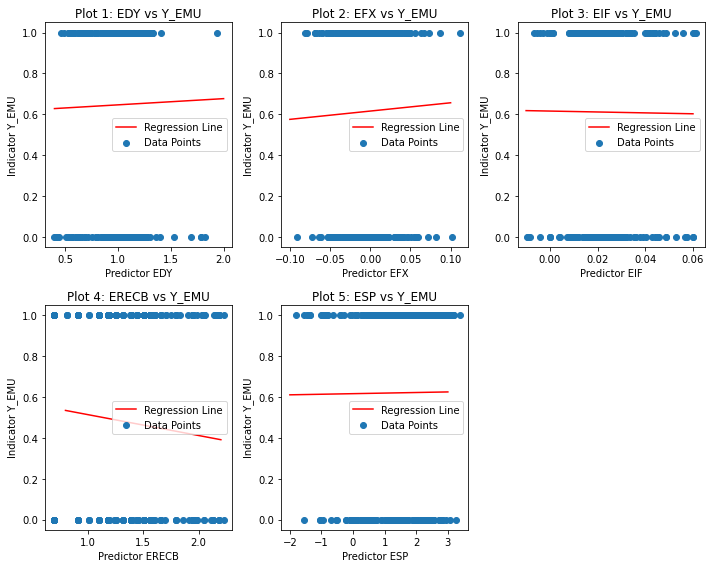

In [ ]:
## EMU plots ##
fig, ax = plt.subplots(2, 3, figsize=(10, 8))

# data for plotting of linear regression line
x1_plot = np.linspace(0.4,2,100)
x2_plot = np.linspace(-0.1,0.1,100)
x3_plot = np.linspace(-0.01,0.06,100)
x4_plot = np.linspace(0.8,2.2,100)
x5_plot = np.linspace(-2,3,100)

y1_plot = x1_plot*OLS_model_EMU.params[1] + OLS_model_US.params[0]
y2_plot = x2_plot*OLS_model_EMU.params[2] + OLS_model_US.params[0]
y3_plot = x3_plot*OLS_model_EMU.params[3] + OLS_model_US.params[0]
y4_plot = x4_plot*OLS_model_EMU.params[4] + OLS_model_US.params[0]
y5_plot = x5_plot*OLS_model_EMU.params[5] + OLS_model_US.params[0]

# first plot 
ax[0,0].scatter(f_new['EDY'], Y_EMU, label='Data Points') 
ax[0,0].plot(x1_plot, y1_plot, color='red', label='Regression Line') 
ax[0,0].set_title('Plot 1: EDY vs Y_EMU')
ax[0,0].set_xlabel('Predictor EDY')
ax[0,0].set_ylabel('Indicator Y_EMU')
ax[0,0].legend()

# second plot 
ax[0,1].scatter(f_new['EFX'], Y_EMU, label='Data Points') 
ax[0,1].plot(x2_plot, y2_plot, color='red', label='Regression Line') 
ax[0,1].set_title('Plot 2: EFX vs Y_EMU')
ax[0,1].set_xlabel('Predictor EFX')
ax[0,1].set_ylabel('Indicator Y_EMU')
ax[0,1].legend()

# third plot 
ax[0,2].scatter(f_new['EIF'], Y_EMU, label='Data Points') 
ax[0,2].plot(x3_plot, y3_plot, color='red', label='Regression Line') 
ax[0,2].set_title('Plot 3: EIF vs Y_EMU')
ax[0,2].set_xlabel('Predictor EIF')
ax[0,2].set_ylabel('Indicator Y_EMU')
ax[0,2].legend()

# fourth plot 
ax[1,0].scatter(f_new['ERECB'], Y_EMU, label='Data Points') 
ax[1,0].plot(x4_plot, y4_plot, color='red', label='Regression Line') 
ax[1,0].set_title('Plot 4: ERECB vs Y_EMU')
ax[1,0].set_xlabel('Predictor ERECB')
ax[1,0].set_ylabel('Indicator Y_EMU')
ax[1,0].legend()

# fifth plot 
ax[1,1].scatter(f_new['ESP'], Y_EMU, label='Data Points') 
ax[1,1].plot(x5_plot, y5_plot, color='red', label='Regression Line') 
ax[1,1].set_title('Plot 5: ESP vs Y_EMU')
ax[1,1].set_xlabel('Predictor ESP')
ax[1,1].set_ylabel('Indicator Y_EMU')
ax[1,1].legend()

# ignore sixth plot 
ax[1, 2].axis('off')

plt.tight_layout()
plt.savefig('high_quality_plot.png', dpi=300) 
plt.show()

**Analysis**:

Similar to the plots for the US, the OLS method is still very bad at modelling binary outputs.

We can also see that the linear regression lines for ESP and EIF have smaller slopes as compared to the other 3 predictors which indicate that market returns are less sensitive to changes in the 2 predictors.

## Part b: Combination of predictors that gives the best performance

Now, we want to evaluate the forecasting performance of our linear regression model. 

We first construct a hit ratio indicator Z as below:


$$
Z_t(\alpha) =
\begin{cases}
1, & \text{if } \widehat{P}(R_{t+1} > 0 \mid X_t) > \alpha \text{ and } R_{t+1} > 0, \\[6pt]
1, & \text{if } \widehat{P}(R_{t+1} > 0 \mid X_t) \le \alpha \text{ and } R_{t+1} \le 0, \\[6pt]
0, & \text{otherwise}.
\end{cases}
$$

where $\alpha = \tfrac{1}{2}$ is a threshold value that we set for part (b) of the problem. 

Essentially, $Z_t(\alpha) = 1$ whenever our OLS model's probability forecast correctly predicts the direction (both positive and non-positive) of the next period's market return. If not, $Z_t(\alpha) = 0$.


To summarize the performance over the entire sample, we compute the average hit ratio:

$$
Z(\alpha) = \frac{1}{n-1} \sum_{t=1}^{n-1} Z_t(\alpha).
$$

This quantity measures the overall classification accuracy of the model:  
- $Z(\alpha) = 1$ means perfect prediction.

---

After estimating the Linear Regression Model in part (a) as below:

$$
Y_{t+1} = \beta' X_t + \varepsilon_t,
$$

Because $Y_{t+1}\$ is a binary variable which takes values of either 0 or 1, the conditional expectation can be interpretation as a probability:

$$
\widehat{P}(R_{t+1} > 0 \mid X_t)
  = \widehat{Y}_{t+1}
  = \widehat{\beta}' X_t.
$$

---
In Python, this probability estimate corresponds to the fitted values from the OLS model using OLS_model.fittedvalues

### US Market

In [ ]:
# create empty list to store final results 
final_result = []

# function to find maximum value of Z(alpha)
def max_Z_finder(f_new, Y_US, pred_USR, alpha = 0.5):
    
    # find all predictors combinations starting from 1 
    for i in range(1, len(pred_USR)+1):
        for combos in combinations(pred_USR, i):
            predictors = list(combos)
            X_ols = f_new[predictors]
            X_ols = sm.add_constant(X_ols)
            
            OLS_model = sm.OLS(Y_US, X_ols).fit()
            
            # estimated probabilities of US stock total excess return 
            estimate_USR = OLS_model.fittedvalues
            
            # construct hit ratio indicator Z 
            rule_1 = (estimate_USR > alpha) & (Y_US == 1)
            rule_2 = (estimate_USR <= alpha) & (Y_US == 0)
            
            # combining rules together to get Z_t 
            Z_t = np.where(rule_1 | rule_2, 1, 0)
            
            # find average Z 
            Z = sum(Z_t)/(len(f_new['Y_USR_forward']))
            
            final_result.append((combos, Z))
            
    return final_result

final_solution_US = max_Z_finder(f_new, Y_US, pred_USR, alpha=0.5)

# Convert final_solution into DataFrame
result_US = pd.DataFrame(final_solution_US, 
                         columns=["Predictor Combinations", "Z(alpha)"])

# Sort returns
result_US = result_US.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
result_US.head(5)

,Predictor Combinations,Z(alpha)
0,"(UDY, UIF, UOIL)",0.634483
1,"(UDY, UIF, URR)",0.627586
2,"(UDY, UIF)",0.624138
3,"(UDY, UOIL)",0.617241
4,"(UIF, UOIL)",0.613793


We can see that the UDY, UIF, and UOIL combination had the maximum Z(alpha) value.

### Eurozone Market

In [ ]:
# create empty list to store final results 
final_result = []

# function to find maximum value of Z(alpha)
def max_Z_finder(f_new, Y_EMU, pred_ESR, alpha = 0.5):
    
    # find all predictors combinations starting from 1 
    for i in range(1, len(pred_ESR)+1):
        for combos in combinations(pred_ESR, i):
            predictors = list(combos)
            X_ols = f_new[predictors]
            X_ols = sm.add_constant(X_ols)
            
            OLS_model = sm.OLS(Y_EMU, X_ols).fit()
            
            # estimated probabilities of Europe stock total excess return 
            estimate_ESR = OLS_model.fittedvalues
            
            # construct hit ratio indicator Z 
            rule_1 = (estimate_ESR > alpha) & (Y_EMU == 1)
            rule_2 = (estimate_ESR <= alpha) & (Y_EMU == 0)
            
            # combining rules together to get Z_t 
            Z_t = np.where(rule_1 | rule_2, 1, 0)
            
            # find average Z 
            Z = sum(Z_t)/(len(f_new['Y_ESR_forward']))
            
            final_result.append((combos, Z))
            
    return final_result

final_solution_EMU = max_Z_finder(f_new, Y_EMU, pred_ESR, alpha=0.5)

# Convert final_solution into DataFrame
result_EMU = pd.DataFrame(final_solution_EMU,\
                          columns=["Predictor Combinations", "Z(alpha)"])

# Sort returns
result_EMU = result_EMU.sort_values("Z(alpha)", \
                                      ascending=False).reset_index(drop=True)

# top 5 results 
result_EMU.head(5)

,Predictor Combinations,Z(alpha)
0,"(EDY, EFX, ERECB)",0.596552
1,"(EDY, EFX, EIF)",0.589655
2,"(EFX, EIF)",0.589655
3,"(EDY, EFX, ERECB, ESP)",0.589655
4,"(EDY, EFX, EIF, ERECB)",0.589655


We can see that the EDY, EFX, and ERECB combination had the maximum Z(alpha) value.

## Part c: Value of alpha to maximize Z(alpha)

Now, with our combinations of predictors from part (b), we want to optimise alpha to generate the maximum $Z(\alpha)$.

### US Market

In [ ]:
# create new array for predictor variables from part (b)
pred_new = ['UDY', 'UIF', 'UOIL']

# define function to find the best alpha 
def maximize_Z(f_new, Y_US, pred_new):
    
    # create empty list to store results
    result = []

    # alpha must be more than 0 and less than 1
    for alpha in np.linspace(1e-10,1,100):
        
        # new predictors from part (b)
        X_new = f_new[pred_new]
        X_new = sm.add_constant(X_new)
        
        OLS_model = sm.OLS(Y_US, X_new).fit()
            
        # estimated probabilities of US stock total excess return 
        estimate_USR = OLS_model.fittedvalues
        
        # construct hit ratio indicator Z 
        rule_1 = (estimate_USR > alpha) & (Y_US == 1)
        rule_2 = (estimate_USR <= alpha) & (Y_US == 0)
            
        # combining rules together to get Z_t 
        Z_t = np.where(rule_1 | rule_2, 1, 0)
            
        Z = sum(Z_t)/(len(f_new['Y_USR_forward']))
        
        result.append((Z, alpha))
                      
    return result 

US_sol = maximize_Z(f_new, Y_US, pred_new)

# Convert final_solution into DataFrame
US_c = pd.DataFrame(US_sol, columns=["Z(alpha)", "alpha"])

# Sort returns
US_c = US_c.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
US_c.head(5)

,Z(alpha),alpha
0,0.655172,0.555556
1,0.648276,0.565657
2,0.637931,0.505051
3,0.637931,0.535354
4,0.637931,0.525253


The best alpha which maximizes Z(alpha) is 0.556.

### Eurozone Market

In [ ]:
# create new array for predictor variables from part (b)
pred_new = ['EDY', 'EFX', 'ERECB']

# define function to find the best alpha 
def maximize_Z(f_new, Y_EMU, pred_new):
    
    # create empty list to store results
    result = []

    # alpha must be more than 0 and less than 1
    for alpha in np.linspace(1e-10,1,1000):
        
        # new predictors from part (b)
        X_new = f_new[pred_new]
        X_new = sm.add_constant(X_new)
        
        OLS_model = sm.OLS(Y_EMU, X_new).fit()
            
        # estimated probabilities of Europe stock total excess return 
        estimate_ESR = OLS_model.fittedvalues
        
        # construct hit ratio indicator Z 
        rule_1 = (estimate_ESR > alpha) & (Y_EMU == 1)
        rule_2 = (estimate_ESR <= alpha) & (Y_EMU == 0)
            
        # combining rules together to get Z_t 
        Z_t = np.where(rule_1 | rule_2, 1, 0)
            
        Z = sum(Z_t)/(len(f_new['Y_ESR_forward']))
        
        result.append((Z, alpha))
                      
    return result 

EMU_sol = maximize_Z(f_new, Y_EMU, pred_new)

# Convert final_solution into DataFrame
EMU_c = pd.DataFrame(EMU_sol, columns=["Z(alpha)", "alpha"])

# Sort returns
EMU_c = EMU_c.sort_values("Z(alpha)", ascending=False).reset_index(drop=True)

# top 5 results 
EMU_c.head(5)

,Z(alpha),alpha
0,0.600000,0.500501
1,0.596552,0.499499
2,0.596552,0.501502
3,0.593103,0.516517
4,0.593103,0.515516


The best alpha which maximizes Z(alpha) is 0.5005.

# Question 3 (CIR model for the term structure of interest rate) <a name="Q3"></a>